In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

In [3]:
from snowexsql.data import PointData, ImageData

In [4]:
from metloom.pointdata import SnotelPointData
import geopandas as gpd

# Pull in Snotel point 
sntl_point = SnotelPointData("622:CO:SNTL", "Mesa Lakes")
geom = sntl_point.metadata
geom = gpd.GeoSeries(geom).set_crs(4326).to_crs(26912).geometry.values[0]


In [5]:
# import necessary libraries
from snowexsql.data import SiteData
from snowexsql.conversions import raster_to_rasterio, query_to_geopandas
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
from geoalchemy2.shape import from_shape,to_shape
from rasterio.plot import show
from sqlalchemy.sql import func

In [6]:
# Buffer distance from site in meters
buffer_dist = 1000

# grab a session
engine, session = get_db(db_name)

# Building a buffer which will give us a buffer object around our point
buffer = session.query(gfunc.ST_SetSRID(gfunc.ST_Buffer(from_shape(geom), buffer_dist), 26912)).all()[0][0]

# Convert to a shapely shapefile object
circle = to_shape(buffer)

# Convert to a geopandas dataframe
df_circle = gpd.GeoSeries(circle)

# Grab the rasters, union them and convert them as tiff when done
q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

# Only grab rasters that are the bare earth DEM from USGS
q = q.filter(ImageData.type == 'DEM').filter(ImageData.observers=='USGS')

# And grab rasters touching the circle
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffer))

# Execute the query
rasters = q.all()

# Get the rasterio object of the raster
dataset = raster_to_rasterio(session, rasters)[0]

/tmp/ipykernel_547/3515782092.py:8: SAWarning: Class ST_SetSRID will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  buffer = session.query(gfunc.ST_SetSRID(gfunc.ST_Buffer(from_shape(geom), buffer_dist), 26912)).all()[0][0]
/tmp/ipykernel_547/3515782092.py:26: SAWarning: Class ST_Union will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if

<AxesSubplot:>

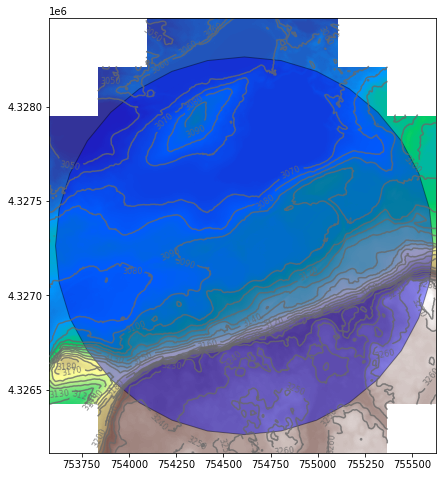

In [7]:

# Create a single plot to add everything to
fig, ax = plt.subplots(figsize=(8,8))

# Plot the DEM
img = show(dataset, ax=ax, transform=dataset.transform, cmap='terrain')

# Plot the contours of the DEM (Just for kicks!) at 10m intervals
show(dataset, contour=True, levels=[s for s in np.arange(3000, 4000, 10)], colors='dimgray', ax=ax, transform=dataset.transform)

# Plot the circle as blue with slight transparency
df_circle.plot(ax=ax, color='b', alpha=0.4, edgecolor='black')

